# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [143]:
import torchvision.models
%matplotlib inline
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import ToTensor, v2
from torch.nn import functional as F
from scipy import io as sio

torch.manual_seed(30)

In [144]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [145]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    v2.ToPILImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    # These are the values I have calculated
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

valid_transform = transforms.Compose([
    v2.PILToTensor(),
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    v2.PILToTensor(),
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [146]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='',
    split="val",
    download=True,
    transform=valid_transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='',
    split="test",
    download=True,
    transform=test_transform
)

# Get the targets and ids
image_labels = sio.loadmat("flowers-102/imagelabels")
setids = sio.loadmat("flowers-102/setid")
print(setids['trnid'])

[[6765 6755 6768 ... 8026 8036 8041]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


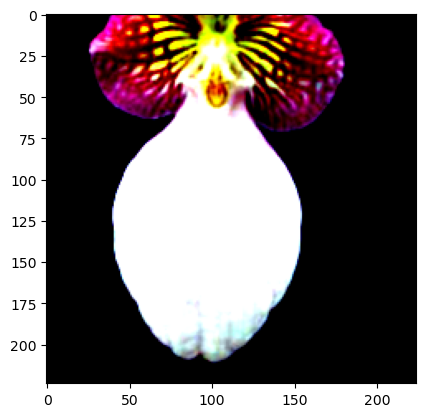

In [147]:
image, label = train_dataset[12]
plt.imshow(image.cpu().permute(1,2,0))

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


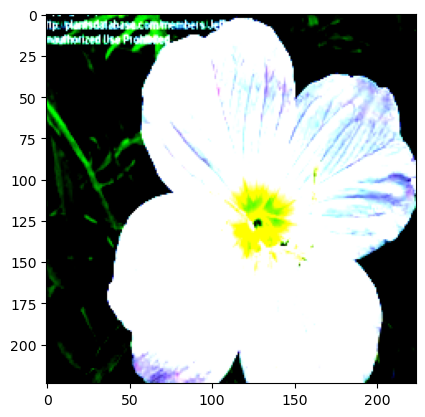

In [148]:
# look at the first training sample
image, label = train_dataset[1]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


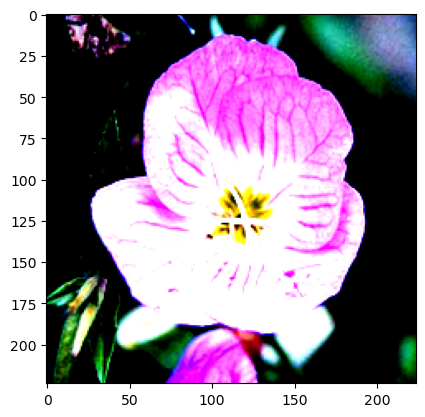

In [149]:
image2, label = test_dataset[0]
plt.imshow(image2.cpu().permute(1, 2, 0))

## Model
I am first going to implement a very basic Convolutional Neural Network as these work well with images

### Model 1

In [150]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Identify a lot of features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten(1)

        self.fc1 = nn.Linear(16 * 53 * 53, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, 102)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Batch is the 1st dimension, image dimensions are 2nd and 3rd
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

This architecture gave me an accuracy of 12% on the validation dataset. I will now attempt to use more channels and see if this improves the performance:

### Model 2

In [151]:
# Making my Convolutional Neural Network
class MyNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Feature Learning ###
        # 3 Input channels
        self.conv1 = nn.Conv2d(3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # ### Classification ###
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        
        # After the 3rd convolutional layer, the filters will have dimensions 26x26
        # 128 x 28 x 28 features
        self.fc1 = nn.Linear(64*28*28, 2048)
        # Classify into one of the flower categories
        self.fc2 = nn.Linear(2048, 102)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn3(x)
        
        # Flatten the tensor for fully connected layers        
        x = self.flatten(x)
        x = nn.Dropout(0.2)(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Second Architecture was also poor (~22% accuracy). I will attempt to perform batch normalisation as well as using more convolutions per layer:

### Model 3

In [152]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                nn.LeakyReLU(),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        # Hold the residual, which will be added to the output
        residual = self.downsample(x) if self.downsample is not None else x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)
        out += residual
        out = self.relu(out)
        return out

class MyNN3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        
        self.cb1 = ConvBlock(16, 16, 3, 1, 1)
        self.cb2 = ConvBlock(16, 32, 3, 1, 1)
        self.cb3 = ConvBlock(32, 64, 3, 1, 1)
        self.cb4 = ConvBlock(64, 128, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
            
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*14*14, 512)
        self.fc2 = nn.Linear(512, 102)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        x = self.cb1(x)
        x = self.maxpool(x)
        x = self.cb2(x)
        x = self.maxpool(x)
        x = self.cb3(x)
        x = self.maxpool(x)
        x = self.cb4(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Model 4

In [153]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Hold the residual, which will be added to the output
        residual = self.downsample(x) if self.downsample is not None else x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += residual
        out = self.relu(out)
        return out


class MyNN4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.cb1 = ConvBlock(16, 32, 3, 1, 1)
        self.cb2 = ConvBlock(32, 64, 3, 1, 1)
        self.cb3 = ConvBlock(64, 128, 3, 1, 1)
        self.cb4 = ConvBlock(128, 256, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*14*14, 512)
        self.fc2 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        x = self.cb1(x)
        x = self.maxpool(x)
        x = self.cb2(x)
        x = self.maxpool(x)
        x = self.cb3(x)
        x = self.maxpool(x)
        x = self.cb4(x)
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

This aims to be slightly simpler by creating a bottleneck.

### Model 5

In [154]:
class MyNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(16*224*224, 2048)
        self.fc2 = nn.Linear(2048, 102)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

### Model 6

In [155]:
class MyNN6(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        
        # Gradually build up features
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*7*7, 8192),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.fc3 = nn.Linear(1024, 102)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 7

In [156]:
class MyNN7(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        # output of sequence is 56x56x64
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        
        # Gradually build up features
        # output is 28x28x128
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        # output is 14x14x256
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        # output is 7x7x32
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(32*7*7, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        self.fc3 = nn.Linear(512, 102)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 8
Here, I am going to try reduce the number of pooling layers, as information may be lost when using too many

In [157]:
class MyNN8(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.BatchNorm2d(128)
        # )
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Sequential(
            nn.Linear(128*14*14, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.fc2 = nn.Linear(2048, 102)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### Model 9

In [158]:
class ResidualBlock(nn.Module):    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.relu = nn.ReLU()
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        
        out = self.layer1(x)
        out = self.layer2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        return out

In [159]:
class MyNN9(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.inplanes = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ) # output, 64 x 56 x 56
        
        self.layer1 = self.layer(ResidualBlock, 64, 3)
        self.layer2 = self.layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.layer(ResidualBlock, 512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 102)
        )
        
    def layer(self, block, planes, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        return x

### Model 10

In [160]:
model = MyNN6().to(device)

## Loss Function

In [161]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()
criterion = nn.

## Optimiser

In [162]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
optimiser = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# optimiser = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)

## Training

In [163]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, generator=torch.Generator(device=device), pin_memory=True)

In [164]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=4, generator=torch.Generator(device=device))

In [165]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimiser.zero_grad(set_to_none=True)
        loss.backward()
        optimiser.step()
    
    train_loss = 0.
    correct = 0
    
    model.eval()
    with torch.no_grad():
        # Get the loss/accuracy of the training set
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= len(dataloader.dataset)
        train_loss /= len(dataloader)
        print(f"Training Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, correct

In [166]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Validation Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return correct, val_loss

In [167]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False

In [168]:
def train_val_model(model, train_loader, val_loader, criterion, optimizer, epoch, path):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_acc = 0.
    # For enhanced GPU performance
    if device == 'cuda':
        torch.backends.cudnn.benchmark = True
        
    # early_stopper = EarlyStopping(patience=15, min_delta=0.01)
    
    print("[INFO] Training starting...")
    start_time = time.time()
    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        train_loss, train_accuracy = train(train_loader, model, criterion, optimiser)
        val_acc, val_loss = validate(valid_loader, model, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        # if early_stopper.early_stop_check(val_loss):             
        #     break
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH)
            
    finish_time = time.time()
    print("[INFO] Testing and training completed.")
    print(f"Elapsed time: {math.floor((finish_time-start_time)/60)}:{math.floor((finish_time-start_time)%60)}")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [169]:
epochs = 100
PATH = 'models/model6.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_val_model(model, train_loader, valid_loader, criterion, optimiser, epochs, PATH)

[INFO] Training starting...
Epoch 1
-------------------------------
Training Error: 
Accuracy: 9.3%, Avg loss: 4.485732 

Validation Error: 
Accuracy: 8.4%, Avg loss: 4.502113 

Epoch 2
-------------------------------
Training Error: 
Accuracy: 13.5%, Avg loss: 3.947084 

Validation Error: 
Accuracy: 10.6%, Avg loss: 4.041567 

Epoch 3
-------------------------------
Training Error: 
Accuracy: 16.8%, Avg loss: 3.515433 

Validation Error: 
Accuracy: 13.4%, Avg loss: 3.672477 

Epoch 4
-------------------------------
Training Error: 
Accuracy: 24.7%, Avg loss: 3.141697 

Validation Error: 
Accuracy: 20.5%, Avg loss: 3.414829 

Epoch 5
-------------------------------
Training Error: 
Accuracy: 27.9%, Avg loss: 2.871313 

Validation Error: 
Accuracy: 21.3%, Avg loss: 3.219691 

Epoch 6
-------------------------------
Training Error: 
Accuracy: 31.5%, Avg loss: 2.672580 

Validation Error: 
Accuracy: 22.8%, Avg loss: 3.137666 

Epoch 7
-------------------------------
Training Error: 
Accur

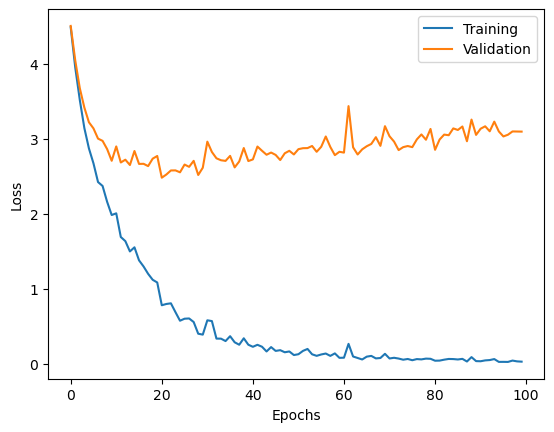

In [170]:
# Visualise the losses
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

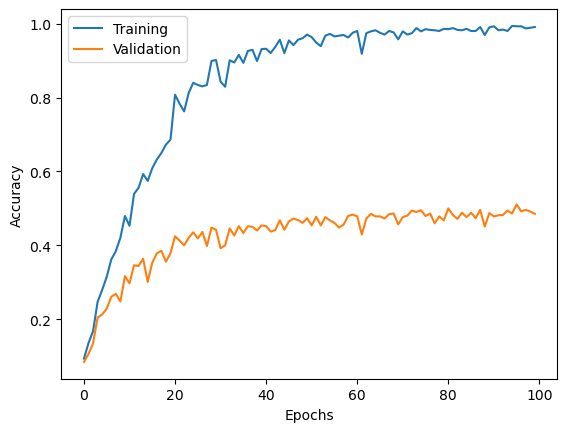

In [171]:
# Visualise the accuracy
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing

In [172]:
# Test on test dataset
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, generator=torch.Generator(device=device))

In [173]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)
            
            # Check each image's prediction
            acc += (predicted.argmax(1) == y).type(torch.float).sum().item()
    model.train()
    return acc/len(test_loader.dataset)

In [174]:
test_model = MyNN6().to(device)
test_model.load_state_dict(torch.load(PATH))
test_acc = test(test_model, test_loader)

In [175]:
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 45.18%
